In [25]:
import pandas as pd
invite = pd.read_csv('data/invited_info_train.txt', sep='\t', header=None)
question = pd.read_csv('data/question_info.txt', sep='\t', header=None)
user = pd.read_csv('data/user_info.txt', sep='\t', header=None)
validate = pd.read_csv('data/validate_nolabel.txt', sep=',')

In [26]:
# deal with text with word2vec
import numpy as np
import gensim
def transform(series, dimension=100):
    row = series.index
    sentenses = series.str.split('/').dropna()
    model = gensim.models.Word2Vec(sentenses, workers=4, min_count=1, size=dimension)
    out = []
    for sentence in sentenses:
        result = np.zeros(dimension)
        count = 0
        for word in sentence:
            result += model[word]
            count +=1
        result = result / float(count)
        out.append(result)
    df = pd.DataFrame(out , index=sentenses.index).reindex(row).fillna(0)
    return df

In [28]:
# formulate the feature
question_new = pd.concat([question.drop([2,3], axis=1), transform(question[2]), transform(question[3])], axis=1)
user_new = pd.concat([user.drop([1,2,3], axis=1), transform(user[1], 50),
                          transform(user[2]), transform(user[3])], axis=1)

                                     0         0         1         2   \
0      61fa06d8908d0e4710a599f970f0ab5a -0.066930 -0.174454  0.153377   
1      4588a1df2461674252ff01c63b59171a -0.000393 -0.331274  0.378449   
2      e8a0f6906978da77dab3d1d779bf2904  0.240979 -0.278268 -0.037774   
3      ab01652daaa15bcbbb21b7c02a8f3646  0.001400 -0.008922  0.005325   
4      4c3694faef04ea6cce28d9d838fc3dda  0.017608 -0.627698  0.235007   
5      de5ee6f16417420e8c6825061bbf1a83 -0.267093 -0.832872  0.977710   
6      1942ce13dc97f455b9a477818ede2b45  0.002624 -0.321764  0.357551   
7      051f10227083374795feec803e1421f5  0.230599 -0.183536  0.058481   
8      8f23f2630ad7656cb08a412ede813fe6 -0.066930 -0.174454  0.153377   
9      b2b0bf186c637e270c948c74f56a12a2  0.014916 -0.167547  0.067845   
10     7afc29fd55e9ade2184aefaee6062f35  0.033663 -0.184315  0.037245   
11     7b083922228600544bb738cd94f3fe7b -0.031482 -0.148679  0.113074   
12     f37635bcd54355ced64ff62b113bc692  0.001980 -

In [29]:
# conbine three files
left = invite
right1 = user_new
right2 = question_new
left.columns = validate.columns
right1_columns = [left.columns[1]]
right1_columns.extend(list(range(right1.columns.size-1)))
right1.columns = right1_columns
right2_columns = [left.columns[0]]
right2_columns.extend(list(range(right2.columns.size-1)))
right2.columns = right2_columns
left = pd.merge(left, right1, how='left', on=[invite.columns[1]])
left = pd.merge(left, right2, how='left', on=[invite.columns[0]])

In [30]:
# get data and label
data = left.drop(invite.columns, axis=1)
label = left[invite.columns[2]]

In [31]:
# deal with missing data and normalization
from sklearn.preprocessing import StandardScaler, Imputer
impute = Imputer()
data = pd.DataFrame(impute.fit_transform(data), index=data.index)
std = StandardScaler()
data = pd.DataFrame(std.fit_transform(data), index=data.index)
print data

             0         1         2         3         4         5         6    \
0       1.014873  0.455512 -0.542344 -0.616916 -0.218880 -0.346227 -0.910798   
1       3.616896 -3.726429 -1.973221 -2.144021  1.086725  2.224714 -1.012421   
2       1.014873  0.455512 -0.542344 -0.616916 -0.218880 -0.346227 -0.910798   
3      -1.773514 -0.323685  1.550068 -0.725664  0.465163 -0.247820 -0.023059   
4      -0.351881  1.025908 -0.848086  0.419744 -0.368249  0.640591 -0.729850   
5      -0.365492  1.037829 -0.824776  0.403744 -0.422679  0.623121 -0.767299   
6      -0.140284 -0.762161  0.528600  1.417665 -1.225807 -1.095538  1.630530   
7      -0.031132 -1.038979  0.725184  1.500325 -1.296443 -1.314184  1.837430   
8      -0.010956 -1.018695  0.764441  1.475983 -1.271184 -1.261138  1.815716   
9      -0.268146  1.052863 -0.817629  0.381050 -0.369737  0.674198 -0.735327   
10      0.045774 -1.171476  0.853700  1.490380 -1.351996 -1.379282  1.928287   
11     -1.744568 -0.344815  1.499970 -0.

In [32]:
# train test split
from sklearn.cross_validation import train_test_split
train_data, test_data, train_label, test_label = train_test_split(data, label, random_state=456, 
                                                                  test_size=0.2, stratify=label)

In [34]:
# load model xgboost
from xgboost import XGBClassifier
gbm = XGBClassifier()

In [41]:
print gbm.booster
print test_data

<bound method XGBClassifier.booster of XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.9, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5)>
             0         1         2         3         4         5         6    \
113412  0.985798  0.468471 -0.414920 -0.587727 -0.241687 -0.270631 -0.919700   
241864 -0.211986 -1.051993  0.746597  1.413872 -1.446474 -1.311478  1.995318   
144581  1.014873  0.455512 -0.542344 -0.616916 -0.218880 -0.346227 -0.910798   
140767 -0.379214 -0.152264  1.598603  1.554290  2.819629 -1.150999  1.004144   
183113 -0.019367 -1.036166  0.705862  1.460032 -1.261785 -1.265569  1.782713   
139199  3.705527 -3.739313 -2.002357 -2.163081  1.102392  2.214634 -1.049854   
202867 -0.705298  0.497194  0.189244 -0.212425 -0.092580  0.7639

In [37]:
# test the model
gbm.set_params(**{'n_estimators':100, 'learning_rate':0.9, 'subsample':0.5, 'colsample_bytree':0.5, 'max_depth':4})
gbm.fit(train_data, train_label, 
        eval_set = [(train_data, train_label), (test_data, test_label)],
        eval_metric = 'auc', verbose=True)

[0]	validation_0-auc:0.644193	validation_1-auc:0.645511
[1]	validation_0-auc:0.676087	validation_1-auc:0.670471
[2]	validation_0-auc:0.684274	validation_1-auc:0.677598
[3]	validation_0-auc:0.695099	validation_1-auc:0.687317
[4]	validation_0-auc:0.703293	validation_1-auc:0.693939
[5]	validation_0-auc:0.709897	validation_1-auc:0.700416
[6]	validation_0-auc:0.71724	validation_1-auc:0.708327
[7]	validation_0-auc:0.722501	validation_1-auc:0.711881
[8]	validation_0-auc:0.726833	validation_1-auc:0.715907
[9]	validation_0-auc:0.732117	validation_1-auc:0.720894
[10]	validation_0-auc:0.734536	validation_1-auc:0.722328
[11]	validation_0-auc:0.73619	validation_1-auc:0.723169
[12]	validation_0-auc:0.742117	validation_1-auc:0.728407
[13]	validation_0-auc:0.745399	validation_1-auc:0.730615
[14]	validation_0-auc:0.746621	validation_1-auc:0.731105
[15]	validation_0-auc:0.749779	validation_1-auc:0.734775
[16]	validation_0-auc:0.755216	validation_1-auc:0.740301
[17]	validation_0-auc:0.758383	validation_1

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.9, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5)

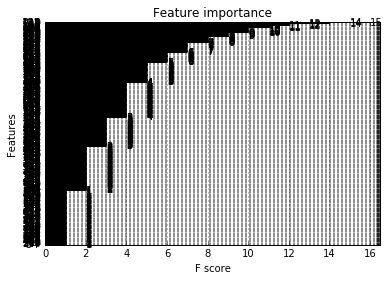

In [39]:
# plot the important feature
import xgboost
%matplotlib inline
xgboost.plot_importance(gbm.booster())

In [12]:
# reformulate feature
result = gbm.booster().get_fscore()
se = pd.Series(result)
important_feature = pd.to_numeric(se[lambda x: x>10].index)
data_important = data[important_feature]

In [13]:
# train and test split
from sklearn.cross_validation import train_test_split
train_data, test_data, train_label, test_label = train_test_split(data_important, label, random_state=456, 
                                                                  test_size=0.2, stratify=label)

In [ ]:
# test
gbm.set_params(**{'n_estimators':600, 'learning_rate':0.9, 'subsample':0.5, 'colsample_bytree':0.5, 'max_depth':4})
gbm.fit(train_data, train_label, 
        eval_set = [(train_data, train_label), (test_data, test_label)],
        eval_metric = 'auc', verbose=True)

[0]	validation_0-auc:0.569472	validation_1-auc:0.574668
[1]	validation_0-auc:0.630363	validation_1-auc:0.62244
[2]	validation_0-auc:0.647494	validation_1-auc:0.63569
[3]	validation_0-auc:0.665247	validation_1-auc:0.651728
[4]	validation_0-auc:0.673346	validation_1-auc:0.660494
[5]	validation_0-auc:0.683382	validation_1-auc:0.669337
[6]	validation_0-auc:0.691671	validation_1-auc:0.675724
[7]	validation_0-auc:0.698352	validation_1-auc:0.681157
[8]	validation_0-auc:0.704329	validation_1-auc:0.686105
[9]	validation_0-auc:0.709606	validation_1-auc:0.692139
[10]	validation_0-auc:0.715234	validation_1-auc:0.697977
[11]	validation_0-auc:0.721239	validation_1-auc:0.704055
[12]	validation_0-auc:0.725482	validation_1-auc:0.707818
[13]	validation_0-auc:0.73143	validation_1-auc:0.711316
[14]	validation_0-auc:0.736597	validation_1-auc:0.715424
[15]	validation_0-auc:0.741325	validation_1-auc:0.719752
[16]	validation_0-auc:0.744305	validation_1-auc:0.722202
[17]	validation_0-auc:0.747354	validation_1-

In [14]:
# get the predicted label
pred_label = pd.Series(gbm.predict_proba(test_data)[:,1], index=test_data.index)

ValueError: feature_names mismatch: ['0  ', '1  ', '2  ', '3  ', '4  ', '5  ', '6  ', '7  ', '8  ', '9  ', '10 ', '11 ', '12 ', '13 ', '14 ', '15 ', '16 ', '17 ', '18 ', '19 ', '20 ', '21 ', '22 ', '23 ', '24 ', '25 ', '26 ', '27 ', '28 ', '29 ', '30 ', '31 ', '32 ', '33 ', '34 ', '35 ', '36 ', '37 ', '38 ', '39 ', '40 ', '41 ', '42 ', '43 ', '44 ', '45 ', '46 ', '47 ', '48 ', '49 ', '50 ', '51 ', '52 ', '53 ', '54 ', '55 ', '56 ', '57 ', '58 ', '59 ', '60 ', '61 ', '62 ', '63 ', '64 ', '65 ', '66 ', '67 ', '68 ', '69 ', '70 ', '71 ', '72 ', '73 ', '74 ', '75 ', '76 ', '77 ', '78 ', '79 ', '80 ', '81 ', '82 ', '83 ', '84 ', '85 ', '86 ', '87 ', '88 ', '89 ', '90 ', '91 ', '92 ', '93 ', '94 ', '95 ', '96 ', '97 ', '98 ', '99 ', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393', '394', '395', '396', '397', '398', '399', '400', '401', '402', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '430', '431', '432', '433', '434', '435', '436', '437', '438', '439', '440', '441', '442', '443', '444', '445', '446', '447', '448', '449', '450', '451', '452', '453'] ['100', '101', '103', '105', '106', '107', '108', '110', '111', '114', '115', '116', '117', '120', '122', '123', '124', '125', '127', '129', '130', '131', '132', '133', '134', '135', '136', '138', '141', '142', '143', '144', '145', '146', '147', '148', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '251', '252', '253', '255', '260', '262', '263', '264', '265', '267', '268', '271', '272', '273', '274', '275', '276', '279', '285', '286', '287', '289', '291', '292', '293', '298', '299', '300', '301', '302', '303', '304', '305', '306', '310', '311', '314', '318', '319', '322', '323', '325', '327', '329', '330', '332', '334', '337', '338', '339', '340', '342', '344', '346', '347', '349', '350', '351', '353', '354', '373', '375', '376', '382', '384', '389', '390', '392', '393', '399', '400', '401', '402', '404', '407', '413', '416', '431', '435', '436', '438', '439', '445', '448', '452', '50 ', '52 ', '53 ', '54 ', '55 ', '56 ', '59 ', '60 ', '61 ', '63 ', '65 ', '66 ', '67 ', '68 ', '69 ', '72 ', '73 ', '74 ', '75 ', '76 ', '78 ', '79 ', '81 ', '84 ', '85 ', '86 ', '87 ', '89 ', '90 ', '91 ', '92 ', '93 ', '95 ', '97 ', '98 ', '99 ']
expected 2  , 13 , 49 , 137, 21 , 4  , 139, 34 , 40 , 28 , 345, 405, 0  , 403, 341, 343, 281, 280, 283, 282, 348, 284, 409, 408, 12 , 453, 121, 261, 266, 126, 420, 128, 269, 423, 71 , 118, 422, 41 , 259, 37 , 82 , 29 , 424, 379, 378, 417, 410, 411, 412, 371, 370, 294, 372, 418, 374, 377, 27 , 308, 9  , 39 , 11 , 313, 312, 317, 316, 315, 270, 30 , 391, 397, 396, 395, 277, 278, 398, 70 , 19 , 414, 415, 42 , 7  , 36 , 257, 429, 428, 83 , 254, 368, 369, 366, 367, 364, 365, 362, 363, 360, 361, 38 , 309, 449, 24 , 48 , 443, 442, 10 , 440, 447, 446, 3  , 444, 380, 296, 109, 385, 58 , 297, 102, 44 , 104, 64 , 295, 381, 51 , 43 , 419, 383, 290, 437, 434, 432, 433, 430, 386, 335, 451, 25 , 336, 331, 333, 17 , 388, 258, 62 , 45 , 250, 57 , 256, 33 , 5  , 288, 18 , 406, 1  , 425, 16 , 22 , 46 , 387, 96 , 427, 113, 394, 23 , 15 , 88 , 426, 32 , 31 , 6  , 119, 112, 441, 320, 321, 326, 324, 328, 8  , 140, 307, 450, 149, 20 , 26 , 77 , 14 , 47 , 359, 35 , 80 , 357, 356, 355, 352, 421, 94 , 358 in input data

In [42]:
# formulate the df_true and df_pred
df_true = pd.concat([invite[['qid','uid']].ix[test_label.index,:], 
                     pd.DataFrame(test_label, columns=['label'])], axis=1)
df_pred = pd.concat([invite[['qid','uid']].ix[test_label.index,:], 
                     pd.DataFrame(pred_label, columns=['label'])], axis=1)

In [45]:
# calculate the evaluation result
from ndcg import ndcg_at_k
def evaluate(df_true, df_pred, column_name='qid', label_name='label', method=0):
    keys = df_true.groupby(column_name).groups
    score = 0.0
    count = 0
    
    for key in keys:
        true = df_true[df_true[column_name]==key][label_name]
        pred = df_pred[df_pred[column_name]==key][label_name]
        index = pred.sort_values(ascending=False).index
        r = true.reindex(index).tolist()
        ndcg5 = ndcg_at_k(r, 5, method)
        ndcg10 = ndcg_at_k(r, 10, method)
        result = (ndcg5+ndcg10)/2.0
        score += result
        count += 1
        print result
    return score/float(count)

In [46]:
# test result
r = evaluate(df_true, df_pred, method=1)

0.0
0.0
0.0
0.919720789148
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.833186623705
0.0
0.0
1.0
1.0
0.630929753571
0.5
0.0
0.0
0.0706334864299
0.0
0.0
0.0
0.0
1.0
0.5
0.0
0.386852807235
0.496056525644
0.0
0.0
1.0
0.0
0.0
0.0
0.71533839156
0.0
0.705435041155
0.0
1.0
1.0
0.893448060914
0.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.919720789148
0.0
1.0
1.0
0.0
0.202107346501
0.0
0.0
0.5
0.0
0.0
1.0
0.877215315338
1.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.630929753571
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.630929753571
0.0
1.0
0.306573596383
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.946902429526
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.877215315338
0.0
0.850344905535
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.630929753571
1.0
0.0
0.679731050004
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.630929753571
0.0
0.630929753571
0.609619950008
0.0
0.0
0.0
1.0
0.630929753571
0.967467983489
0.630929753571
0.0
0.0
0.693426403617
0.630929753571
0.0
0.630929753571
1.0
0.0
0.0
1.0
1.0
0.63092975357

In [47]:
r

0.38289588629749716

In [48]:
# get the predicted result of validation_nolabel
left = validate
right1 = user_new
right2 = question_new
#left.columns = validate.columns
right1_columns = [left.columns[1]]
right1_columns.extend(list(range(right1.columns.size-1)))
right1.columns = right1_columns
right2_columns = [left.columns[0]]
right2_columns.extend(list(range(right2.columns.size-1)))
right2.columns = right2_columns
left = pd.merge(left, right1, how='left', on=[validate.columns[1]])
left = pd.merge(left, right2, how='left', on=[validate.columns[0]])
data = left.drop(validate.columns, axis=1)
label = left['label']
from sklearn.preprocessing import StandardScaler, Imputer
impute = Imputer()
data = pd.DataFrame(impute.fit_transform(data), index=data.index)
std = StandardScaler()
data = pd.DataFrame(std.fit_transform(data), index=data.index)
data_important = data[important_feature]
pred_label = pd.Series(gbm.predict_proba(data_important)[:,1], index=data_important.index)
df_pred = pd.concat([validate[['qid','uid']].ix[label.index,:], 
                     pd.DataFrame(pred_label, columns=['label'])], axis=1)

In [54]:
# write the file
df_pred.to_csv('result/submit.csv', index=None, encoding='utf-8')